In [ ]:
%load_ext autoreload
%autoreload 2

import utils
import concurrent.futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import logging as log
import utils
import concurrent.futures
from tqdm import tqdm

In [ ]:
# claim label range is smaller than Liar and Snopes but provides sources like Snopes. Better for fact checking
fever_ds = pd.read_json('drive/MyDrive/Colab Notebooks/TB/datasets/fever_train.jsonl', lines=True)
fever_ds.head()

,id,verifiable,label,claim,evidence
0,75397,VERIFIABLE,SUPPORTS,Nikolaj Coster-Waldau worked with the Fox Broa...,"[[[92206, 104971, Nikolaj_Coster-Waldau, 7], [..."
1,150448,VERIFIABLE,SUPPORTS,Roman Atwood is a content creator.,"[[[174271, 187498, Roman_Atwood, 1]], [[174271..."
2,214861,VERIFIABLE,SUPPORTS,"History of art includes architecture, dance, s...","[[[255136, 254645, History_of_art, 2]]]"
3,156709,VERIFIABLE,REFUTES,Adrienne Bailon is an accountant.,"[[[180804, 193183, Adrienne_Bailon, 0]]]"
4,83235,NOT VERIFIABLE,NOT ENOUGH INFO,System of a Down briefly disbanded in limbo.,"[[[100277, None, None, None]]]"


In [ ]:
fever_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145449 entries, 0 to 145448
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          145449 non-null  int64 
 1   verifiable  145449 non-null  object
 2   label       145449 non-null  object
 3   claim       145449 non-null  object
 4   evidence    145449 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.5+ MB


In [ ]:
print(fever_ds['label'].value_counts())

label
SUPPORTS           80035
NOT ENOUGH INFO    35639
REFUTES            29775
Name: count, dtype: int64


<Axes: xlabel='label'>

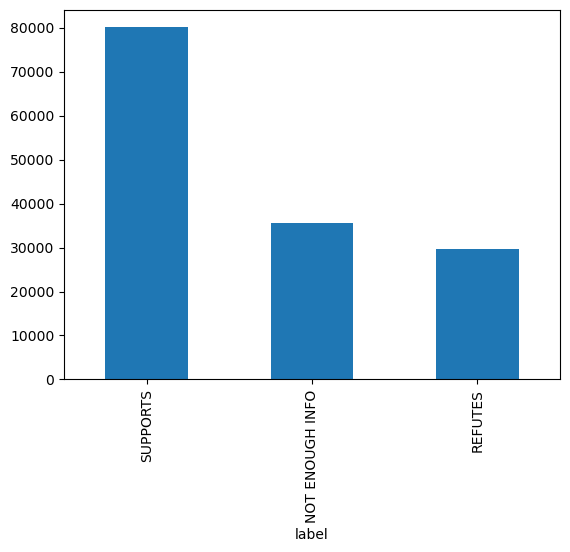

In [ ]:
fever_ds['label'].value_counts().plot(kind='bar')

In [ ]:
columns_to_drop = ['id', 'verifiable']
filtered_fever = fever_ds.drop(columns_to_drop, axis=1)

In [ ]:
filtered_fever = filtered_fever[filtered_fever['label'] != 'NOT ENOUGH INFO']

In [ ]:
print(filtered_fever['label'].value_counts())

label
SUPPORTS    80035
REFUTES     29775
Name: count, dtype: int64


In [ ]:
snopes_ds = pd.read_csv('drive/MyDrive/Colab Notebooks/TB/datasets/snopes_corpus_4.csv')

In [ ]:
snopes_ds['Truthfulness (Verdicts)'] = snopes_ds['Truthfulness (Verdicts)'].replace(['FALSE', 'MOSTLY FALSE'], 'REFUTES')
snopes_ds['Truthfulness (Verdicts)'] = snopes_ds['Truthfulness (Verdicts)'].replace(['TRUE', 'MOSTLY TRUE'], 'SUPPORTS')

In [ ]:
filtered_snopes = snopes_ds[snopes_ds['Truthfulness (Verdicts)'].isin(['REFUTES', 'SUPPORTS'])]
filtered_snopes.rename(columns={
    'Truthfulness (Verdicts)': 'Verdict',
    'Snippets (ETS)': 'ETS',
    'Documents (orginal documents)': 'Document'
}, inplace=True)



columns_to_drop = ['ID', 'Snopes URL', 'Source URL', 'Match ETS and Documents ', 'Source', 'Document']
filtered_snopes.drop(columns_to_drop, axis=1, inplace=True)

verdict_mapping = {
    'REFUTES': 0,
    'SUPPORTS': 1,
}
filtered_snopes['Numerical_Verdict'] = filtered_snopes['Verdict'].map(verdict_mapping)

C:\Users\halim\AppData\Local\Temp\ipykernel_31360\2247206085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_snopes.rename(columns={
C:\Users\halim\AppData\Local\Temp\ipykernel_31360\2247206085.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_snopes.drop(columns_to_drop, axis=1, inplace=True)
C:\Users\halim\AppData\Local\Temp\ipykernel_31360\2247206085.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [ ]:
print(filtered_snopes['Verdict'].value_counts(normalize=True))
print(filtered_fever['label'].value_counts(normalize=True))

Verdict
REFUTES     0.825742
SUPPORTS    0.174258
Name: proportion, dtype: float64
label
SUPPORTS    0.72885
REFUTES     0.27115
Name: proportion, dtype: float64


### Downsample and Retreving data for FEVER

In [ ]:
#fever_shuffled = filtered_fever.sample(frac=1, random_state=42)

In [ ]:
fever_downsampled = pd.concat([
    filtered_fever[filtered_fever['label'] == 'SUPPORTS'].sample(n=len(filtered_snopes[filtered_snopes['Numerical_Verdict'] == 0]), replace=True, random_state=42),
    filtered_fever[filtered_fever['label'] == 'REFUTES'].sample(n=len(filtered_snopes[filtered_snopes['Numerical_Verdict'] == 1]), replace=True, random_state=42)
], axis=0)

fever_downsampled['numerical_label'] = fever_downsampled['label'].map({'SUPPORTS': 1, 'REFUTES': 0})

In [ ]:
print(filtered_snopes['Numerical_Verdict'].value_counts(normalize=True))
print(fever_downsampled['numerical_label'].value_counts(normalize=True))

Numerical_Verdict
0    0.825742
1    0.174258
Name: proportion, dtype: float64
numerical_label
1    0.825742
0    0.174258
Name: proportion, dtype: float64


In [ ]:
print(fever_downsampled['numerical_label'].value_counts())

numerical_label
1    13543
0     2858
Name: count, dtype: int64


In [ ]:
print(filtered_snopes['Numerical_Verdict'].value_counts())

Numerical_Verdict
0    13543
1     2858
Name: count, dtype: int64


In [ ]:
articles = pd.DataFrame(columns=['page', 'data'])

for i in tqdm(fever_downsampled.index, desc="Processing rows", unit="row"):

    if i not in fever_downsampled.index:
        print(f"Index {i} does not exist in the DataFrame. Skipping.")
        continue

    row = fever_downsampled.loc[i]

    try:
        ets, document = utils.get_all_ETS_and_document(row['evidence'], articles)
        #print(">>> OUTPUT ETS: ", ets)
        fever_downsampled.at[i, 'ETS'] = ets
        fever_downsampled.at[i, 'Documents'] = document
    except Exception as e:
        fever_downsampled = fever_downsampled.drop(i)


In [ ]:
fever_downsampled.to_csv('drive/MyDrive/Colab Notebooks/TB/datasets/fever_downsampled.csv', index=True)